In [1]:
from course_settings import set_tf_nthreads
set_tf_nthreads(4) # best setting for this tutorial at CIP

Using TensorFlow backend.
W0910 13:33:37.568431 140689498072896 deprecation_wrapper.py:119] From /filer/z-sv-pool06/m/Mujkanovic.Max/machine_learning/LMU_DA_ML_19Adv/course_settings.py:9: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0910 13:33:37.569808 140689498072896 deprecation_wrapper.py:119] From /filer/z-sv-pool06/m/Mujkanovic.Max/machine_learning/LMU_DA_ML_19Adv/course_settings.py:13: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



# Convolutional neural networks

## ImageNet and the "Deep Learning" Hype
A large portion of the current hype around neural networks has been caused by successes in image recognition, driven by the [ImageNet](http://www.image-net.org/) challenge/dataset. Basically all successful algorithms for computer vision nowadays use in some way Convolutional neural networks in some way.
![imagenet](figures/imagenet.png)
(Image from https://qz.com/1034972/the-data-that-changed-the-direction-of-ai-research-and-possibly-the-world/)

## The convolution operation

Convolutional neural networks make use of the convolution operation. They are mostly used for processing image data with 2D discrete convolutions:

![convolution](figures/convolution.png)

## Let's try it out
Can you guess what the output image for convolutional kernel in the picture above will look like?

It's the Sobel operator (https://en.wikipedia.org/wiki/Sobel_operator) that can be used for edge detection

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

A nice library for loading images into python arrays is pillow (https://pillow.readthedocs.io/en/stable/)

In [4]:
import PIL

In [5]:
grumpy_pil = PIL.Image.open("figures/grumpy.jpg")
grumpy_pil.thumbnail((200, 200))
img_grumpy = np.array(grumpy_pil)

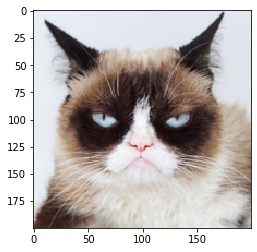

In [6]:
plt.imshow(img_grumpy)

In [8]:
img_grumpy_grey = img_grumpy.mean(axis=2)

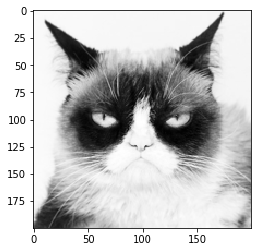

In [9]:
plt.imshow(img_grumpy_grey, cmap="Greys_r")

We could use `scipy.signal` to perform the convolution operation but to understand how the convolution works, let's quickly implement it by manually scanning over the image:

In [11]:
def convolve(input_img, kernel):
    # we will do a "valid" convolution
    # that means the output will be 2 pixels smaller in both directions than the input
    output_img = np.empty(shape=(input_img.shape[0]-2, input_img.shape[1]-2))
    for j in range(output_img.shape[1]):
        for i in range(output_img.shape[0]):
            output_img[i][j] = np.sum(kernel * input_img[i:i+kernel.shape[0], j:j+kernel.shape[1]])
    return output_img

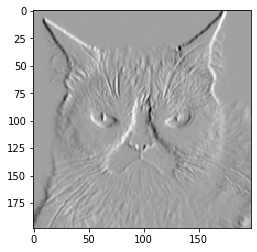

In [12]:
plt.imshow(convolve(img_grumpy_grey, sobel_x), cmap="Greys_r")

Vertical edges got highlighted! In a very simple example:

In [13]:
test_img = np.array([
    [0, 0, 0, 0, 1, 1, 1, 1],
    [0, 0, 0, 0, 1, 1, 1, 1],
    [0, 0, 0, 0, 1, 1, 1, 1],
    [0, 0, 0, 0, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0],
])

In [14]:
convolve(test_img, sobel_x)

array([[ 0.,  0.,  4.,  4.,  0.,  0.],
       [ 0.,  0.,  4.,  4.,  0.,  0.],
       [ 0.,  0.,  3.,  3.,  0.,  0.],
       [ 0.,  0.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1., -1.,  0.,  0.],
       [ 0.,  0., -3., -3.,  0.,  0.],
       [ 0.,  0., -4., -4.,  0.,  0.],
       [ 0.,  0., -4., -4.,  0.,  0.]])

The transposed filter will highlight horizontal edges:

In [15]:
sobel_y = sobel_x.T
sobel_y

array([[-1, -2, -1],
       [ 0,  0,  0],
       [ 1,  2,  1]])

In [16]:
convolve(test_img, sobel_y)

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1., -3., -4., -4.],
       [ 0.,  0., -1., -3., -4., -4.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  4.,  3.,  1.,  0.,  0.],
       [ 4.,  4.,  3.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

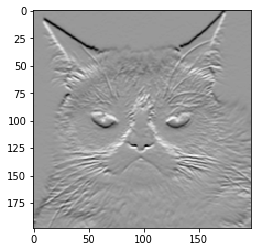

In [17]:
plt.imshow(convolve(img_grumpy_grey, sobel_y), cmap="Greys_r")

And if we quadratically add the pictures above we get a nice highlighting of all edges:

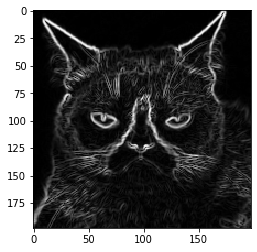

In [18]:
plt.imshow(
    np.sqrt(
        convolve(img_grumpy_grey, sobel_x)**2
        + convolve(img_grumpy_grey, sobel_y)**2
    ),
    cmap="Greys_r"
)

## Application within a neural network

You might imagine that such filters help a lot when processing images and e.g. trying to learn what they show. What a convolutional neural network (CNN) does is instead of using hand-designed filters have them as trainable parameters. We can then have layers with arbitrary many input features (each of them an image) and arbitrary many output features (each of them as well an image) by essentially sliding a neural network over them:

![cnn_layer](figures/cnn_layer.png)

The top row corresponds to the input features - before the first layer these are typically the 3 colors, red, green, blue and the bottom row corresponds to the output features. For each output feature, the neutral network will learn one convolutional kernel for each input feature. So the black lines in the graphic above correspond to the trainable weights.

[animated version](https://homepages.physik.uni-muenchen.de/~Nikolai.Hartmann/cnn_anim.svg)

In Addition to applying the filter one can (and typically will) also apply an activation function.

The big advantage of convolutional layers for image processing is that the same weights are used at different places of the input image for processing. This allows to detect similar features, no matter where they occur in the image - a property sometimes referred to as "translational invariance".

Below is another nice animated visualisation from the [CS231 course](http://cs231n.github.io/) -- here with a convolution of "stride 2", meaning the filters move in steps of 2 pixels over the image. The blue boxes are the inputs (padded with zeros), the red boxes are two filters and the two green boxes corresponds to the output for each of the two filters. (Note that the 3 channels are summed over for the output.)

In [19]:
from IPython.display import IFrame
IFrame('http://cs231n.github.io/assets/conv-demo/index.html', width=800, height=700)

## Pooling layers

In addition to convolutional layers, CNNs will typically perform some kind of downsampling (also called pooling or subsampling) in between. This has several reasons:

- The region of the orgininal image that the neural network can "see" will increase. This can help to make use of correlations between more distant areas within an image
- The amount of computation decreases (smaller images further down in the network) - more depth and/or width of the network can be increased
- Especially for classification problems the total NN output should a few numbers, e.g. indicating in which category an image falls. Successively downsampling the image within the network will help to keep the number of parameters in the last layers small.

Pooling typically takes the maximum, average or sum over a fixed sliding window. An example of "Max" pooling with a 2x2 window:

![max_pooling](figures/Max_pooling.png)


## Full CNN Architecture for image classification

A typical CNN architecture for image classification consists of several convolutional layers with pooling layers in between and a simple fully-connected network as a last step:

![max_pooling](figures/Typical_cnn.png)

The fully connected network either has all output pixels of the last convolutional/pooling layer as input ("flatten") or uses the global average of each output feature of the last convolutional/pooling layer

## Let's try it out - CIFAR10

We will use the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset for trying CNNs. The dataset consists out of 60k 32x32 images, labelled for 10 categories. Our goal is to predict the category from processing the image.

In [20]:
from keras.datasets import cifar10

In [21]:
# copy from /large_tmp/ if at CIP (otherwise keras will just download it from the web)
import os
from shutil import copyfile
path_cifar10_cip = "/large_tmp/LMU_DA_ML_19Adv/cifar-10-batches-py.tar.gz"
path_cifar10_user = os.path.expanduser("~/.keras/datasets/cifar-10-batches-py.tar.gz")
if not os.path.exists(path_cifar10_user) and os.path.exists(path_cifar10_cip):
    os.makedirs(os.path.expanduser("~/.keras/datasets"), exist_ok=True)
    copyfile(path_cifar10_cip, path_cifar10_user)

`data` will contain 2 tuples of X, y for training (50k) and testing (10k) data:

In [22]:
data = cifar10.load_data()
x_train, y_train = data[0]
x_test, y_test = data[1]

Pictures are arranged as arrays with indices (x, y, color):

In [23]:
x_train[0].shape

(32, 32, 3)

The target vector consists of label indices:

In [24]:
y_train[:10]

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3]], dtype=uint8)

The labels are as follows (in that order)

In [25]:
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Let's look at a few random pictures of cats

In [26]:
def show_random_pictures(x):
    pictures = x
    rnd_idx = np.random.permutation(len(pictures))
    fig, axs = plt.subplots(nrows=3, ncols=10, figsize=(20,6))
    for i, ax in enumerate(axs.reshape(-1)):
        ax.imshow(pictures[rnd_idx[i]])
        ax.set_axis_off()

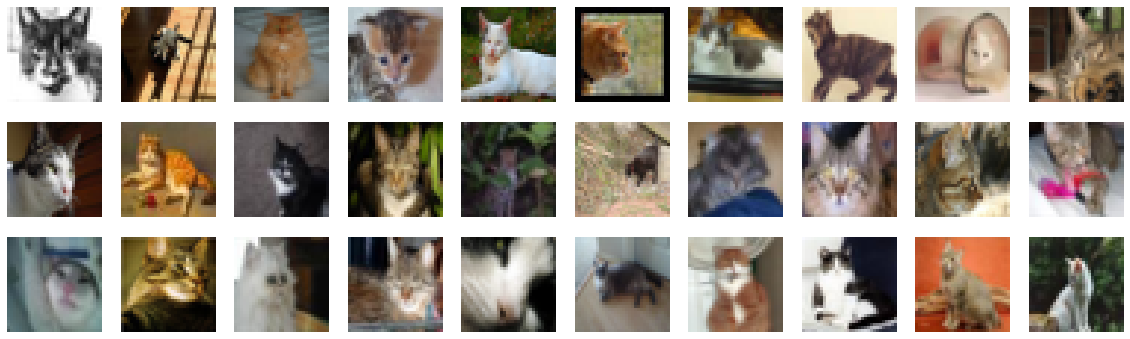

In [27]:
show_random_pictures(x_train[y_train.reshape(-1) == labels.index('cat')])

### Define the NN
Keras has all the components we need

In [28]:
import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout

Let's build a model similar to [keras/examples/cifar10_cnn.py](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py)

In [29]:
model = keras.models.Sequential([
    # lets start with 2 convolutional layers with kernel size 3, 32 output features each
    Conv2D(32, 3, activation="relu", input_shape=(32, 32, 3)),
    Conv2D(32, 3, activation="relu"),
    # Max pooling (default window size is 2x2)
    MaxPooling2D(),
    # Add a 25% Dropout (randomly drops 25% of inputs during training)
    Dropout(0.25),
    # another block of 2 CNN layers with 64 output features each, followed by MaxPooling and Dropout
    Conv2D(64, 3, activation="relu"),
    Conv2D(64, 3, activation="relu"),
    MaxPooling2D(),
    Dropout(0.25),
    # Flatten (reshape) all output pixels of all features into 1D array
    Flatten(),
    # add a fully connected final hidden layer with 512 neurons, followed by 50% dropout
    Dense(512, activation="relu"),
    Dropout(0.5),
    # 10 output neurons that are supposed to represent the 10 categories
    # and output 1 if the image is likely in that category and 0 if not
    Dense(10, activation="softmax")
])

W0910 14:00:59.606288 140689498072896 deprecation_wrapper.py:119] From /software/opt/bionic/x86_64/anaconda3/2019.07/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0910 14:00:59.607922 140689498072896 deprecation_wrapper.py:119] From /software/opt/bionic/x86_64/anaconda3/2019.07/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0910 14:00:59.609678 140689498072896 deprecation_wrapper.py:119] From /software/opt/bionic/x86_64/anaconda3/2019.07/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0910 14:00:59.629211 140689498072896 deprecation_wrapper.py:119] From /software/opt/bionic/x86_64/anaconda3/2019.07/lib/python3.7/site-packages/keras/backend/tensorflow_backend.p

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
__________

For a multi-classification problems the figure of merit to minimize is the categorical cross entropy. We will use the *Adam* optimizer (a state-of-the-art (2019) adaptive learning rate optimizer that we used for the [NN for the Higgs challenge](HiggsChallenge-NN.ipynb)) and tell keras to monitor the *accuracy* (fraction of correctly classified examples) during the training:

In [31]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

W0910 14:01:03.501649 140689498072896 deprecation_wrapper.py:119] From /software/opt/bionic/x86_64/anaconda3/2019.07/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



For preprocessing, we will simply divide by 255 (r, g, b values are between 0 and 255)

In [32]:
def preprocess(x):
    return x / 255.

Since the NN will output 10 values, we "one-hot-encode" our target vector

In [33]:
y_train_onehot = keras.utils.to_categorical(y_train)

In [34]:
y_train[:10]

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3]], dtype=uint8)

In [35]:
y_train_onehot[:10]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Now we are ready to start the training!

In [36]:
history = model.fit(
    # input
    preprocess(x_train),
    # target
    y_train_onehot,
    # number of training examples in each batch
    batch_size=64,
    # shuffle training data after each epoch
    shuffle=True,
    # number of iterations over training dataset
    epochs=5,
    # fraction of training data to split off for validation after each epoch
    validation_split=0.1,
)

W0910 14:01:26.962785 140689498072896 deprecation.py:323] From /software/opt/bionic/x86_64/anaconda3/2019.07/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 45000 samples, validate on 5000 samples
Epoch 1/5
45000/45000 [==============================] - 33s 737us/step - loss: 1.6241 - acc: 0.4011 - val_loss: 1.3643 - val_acc: 0.5094
Epoch 2/5
45000/45000 [==============================] - 32s 716us/step - loss: 1.2626 - acc: 0.5486 - val_loss: 1.1155 - val_acc: 0.5994
Epoch 3/5
45000/45000 [==============================] - 32s 704us/step - loss: 1.1012 - acc: 0.6107 - val_loss: 0.9505 - val_acc: 0.6730
Epoch 4/5
45000/45000 [==============================] - 32s 721us/step - loss: 0.9879 - acc: 0.6500 - val_loss: 0.8438 - val_acc: 0.7100
Epoch 5/5
45000/45000 [==============================] - 32s 701us/step - loss: 0.9142 - acc: 0.6789 - val_loss: 0.7772 - val_acc: 0.7272


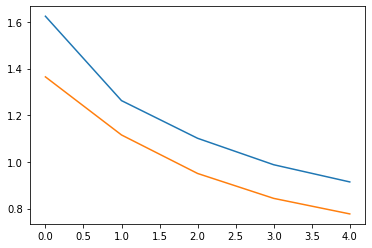

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [38]:
np.min(history.history['val_loss'])

0.7771742084503174

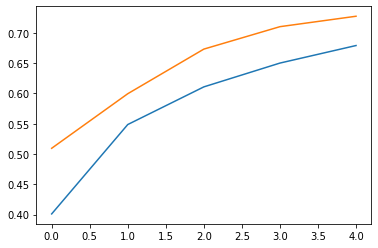

In [39]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [40]:
np.max(history.history['val_acc'])

0.7272

We got around 70% accuracy on the validation sample! This is not perfect yet, but already quite impressive, given the relatively simple model and fast training. From the plots above we can see that the model is maybe not fully converged yet, so a few percent might be gained by continuing the training (you can try just executing the notebook cell above again).

[Current state-of-the art neural networks](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html) reach accuracies of > 95% on CIFAR-10, so there is still a lot of room for optimization.

But now, let's validate our score on the completely independent test sample:

In [41]:
scores = model.predict(preprocess(x_test))

These scores are now the predicted probabilities for each label

In [42]:
scores

array([[2.27724644e-03, 2.42267502e-03, 2.06268448e-02, ...,
        5.98445255e-03, 2.00864300e-02, 5.07604610e-03],
       [4.55330797e-02, 8.69518053e-03, 4.10614484e-06, ...,
        2.37235795e-08, 9.45399284e-01, 3.67107190e-04],
       [3.18384260e-01, 2.95685261e-01, 6.46672165e-03, ...,
        1.66924449e-03, 2.88825959e-01, 8.00919607e-02],
       ...,
       [1.38592495e-05, 1.48069802e-07, 6.38272893e-03, ...,
        7.74607528e-03, 6.29363285e-06, 7.02555269e-07],
       [2.52259940e-01, 3.96089196e-01, 2.22400855e-02, ...,
        9.46441572e-03, 8.37478600e-03, 1.59354950e-03],
       [1.44882961e-06, 8.82839828e-08, 1.01880563e-04, ...,
        9.69716907e-01, 8.77802098e-09, 1.83097271e-07]], dtype=float32)

When we take the index of the highest probability, we get the "best-guess" predicted labels

In [43]:
predicted_labels = np.argmax(scores, axis=1)
predicted_labels

array([3, 8, 0, ..., 5, 1, 7])

In [44]:
acc_test = (predicted_labels == y_test.reshape(-1)).mean()
acc_test

0.712

For such multi class problems it is useful to plot a confusion matrix - telling us how often which label is confused with each of the other labels

In [45]:
from sklearn.metrics import confusion_matrix

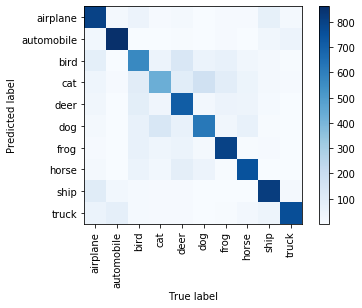

In [46]:
plt.imshow(confusion_matrix(y_test, predicted_labels), plt.cm.Blues)
plt.colorbar()
plt.xticks(range(10), labels, rotation=90)
plt.xlabel("True label")
plt.yticks(range(10), labels)
plt.ylabel("Predicted label")
plt.show()

Our test sample has 10k pictures with 1k for each category, so the perfect confusion matrix would contain the value 1000 all over the diagonal. Overall we see that animals seem to be more difficult to distinguish than vehicles, and vehicles tend to be confused with other vehicles and animals with other animals.

Lets look at a random sample of pictures that our network classifies as "cats":

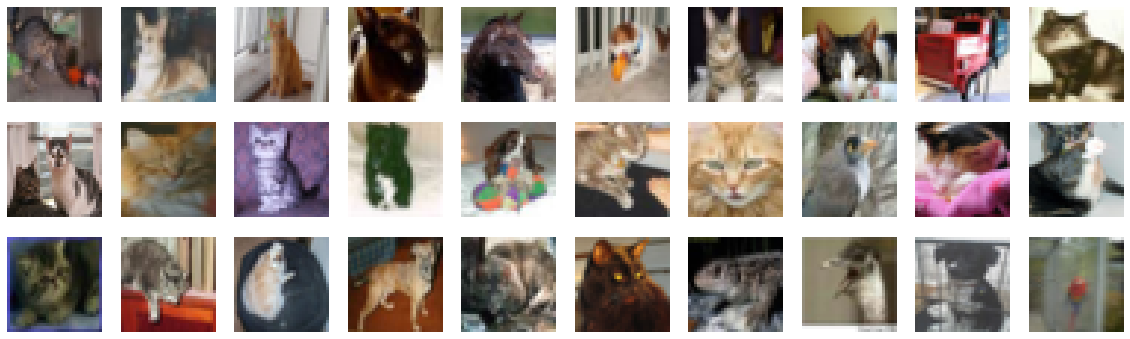

In [47]:
show_random_pictures(x_test[predicted_labels == labels.index('cat')])

Frogs seem to work rather well, but lets look in particular at images that are incorrectly classified as frogs:

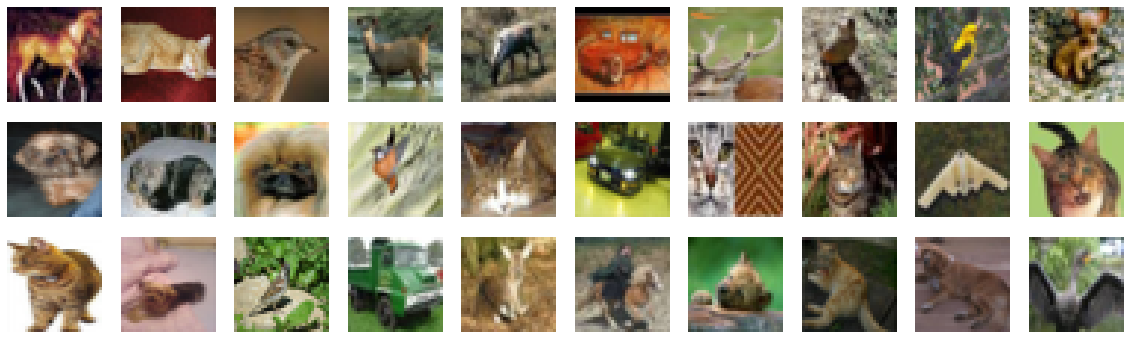

In [48]:
show_random_pictures(x_test[(predicted_labels == labels.index('frog')) & (y_test.reshape(-1) != labels.index('frog'))])

For comparison, some actual frogs:

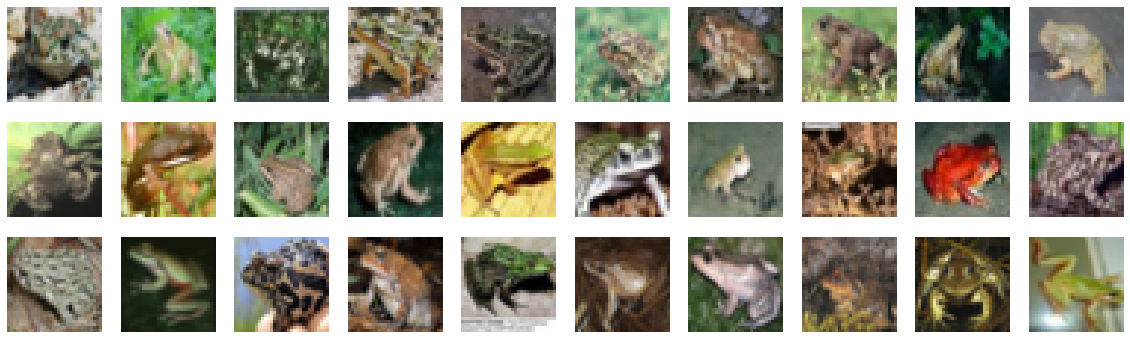

In [49]:
show_random_pictures(x_test[y_test.reshape(-1) == labels.index('frog')])

What's happening with birds that are confused with airplanes?

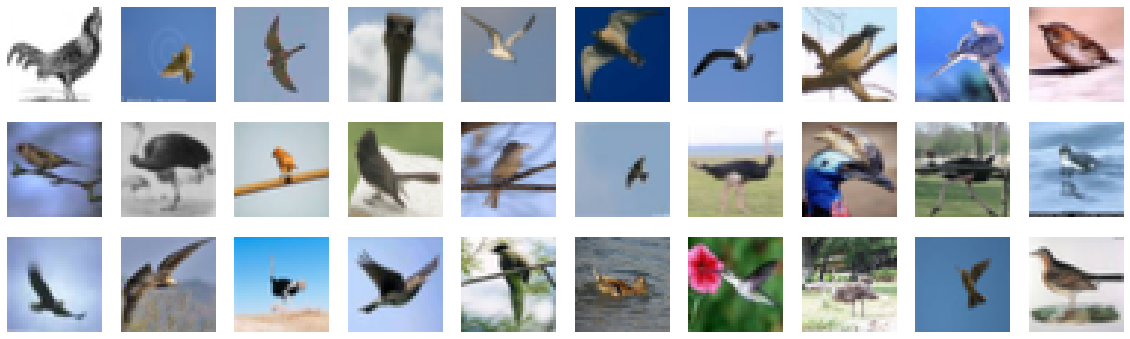

In [50]:
show_random_pictures(x_test[(predicted_labels == labels.index('airplane')) & (y_test.reshape(-1) == labels.index('bird'))])

Lets have a look at the actual predicted probabilites for a few examples:

In [51]:
def plot_probabilities(x, y, scores, index):
    fig, ax = plt.subplots(figsize=(4, 2), nrows=1, ncols=2)
    ax[1].imshow(x[index])
    ax[1].set_title(labels[y[index][0]])
    ax[0].barh(labels, scores[index])
    ax[0].set_xlabel("pred. probability")

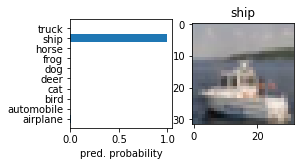

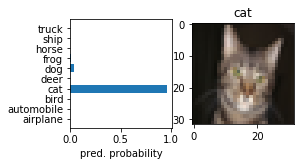

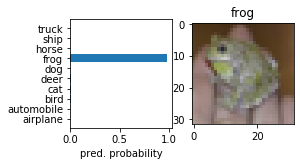

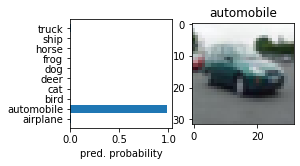

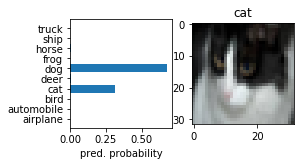

In [52]:
for index in np.random.randint(0, len(x_test), 5):
    plot_probabilities(x_test, y_test, scores, index)

What does our NN say to the grumpy cat image at the beginning of this tutorial? To find out, we must first scale it down to 32x32:

In [53]:
grumpy_32 = np.empty((32, 32, 3))
# split into 32 ~equal parts and average
for ix, x in enumerate(np.array_split(img_grumpy, 32)):
    for iy, y in enumerate(np.array_split(x.mean(axis=0), 32)):
        grumpy_32[ix][iy] = np.mean(y, axis=0)
# normalize
grumpy_32 /= grumpy_32.max()

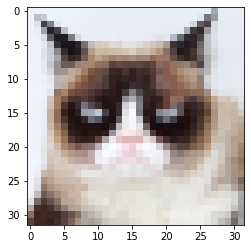

In [54]:
plt.imshow(grumpy_32)

In [55]:
scores_grumpy = model.predict(grumpy_32.reshape(-1, 32, 32, 3))

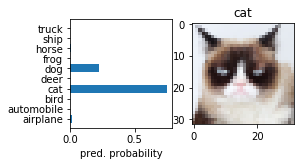

In [56]:
plot_probabilities(grumpy_32.reshape(-1, 32, 32, 3), np.array([[labels.index('cat')]]), scores_grumpy, 0)

We save the trained model for reuse in a later notebook:

In [57]:
model.save("CNNIntro_model.h5")

# What has the network learned?
* CNN very successful at recognizing objects in images (visual classification problems)
    * sometimes with success rates close to humans
    * question thus: what does the network learn? similar to human perception of images?
* often not easy to reason how a certain classification process is done by a neural network
    * big field of research
    * will not cover this hear but give an interesting warning / anecdotal finding
* how can we trick a NN into thinking it sees something else than what the image shows?
    * surprisingly (alarmingly?) easy
* below: results from two papers from 2013 and 2014
    * Christian Szegedy, Wojciech Zaremba, Ilya Sutskever, Joan Bruna, Dumitru Erhan, Ian Goodfellow, Rob Fergus, "Intriguing properties of neural networks", [arXiv:1312.6199 [cs.CV]][1]
    * Anh Nguyen, Jason Yosinski, Jeff Clune, "Deep Neural Networks are Easily Fooled: High Confidence Predictions for Unrecognizable Images", [arXiv:1412.1897 [cs.CV]][2]
    
[1]: https://arxiv.org/abs/1312.6199
[2]: https://arxiv.org/abs/1412.1897

## Adversarial images
* examples of images that have been tuned to look like an ostrich (*struthio camelus*) to the neural network:

![figure 5 from 1312.6199][1]

* in each block there are 3 images:
    * the left images are the original images (correctly classified)
    * the right images are the modified images (looking the same to the human eye)
    * the middle images are the differences, magnified by a factor 10

* reminder: this is a *struthio camelus* (image by MathKnight, clipped, CC BY-SA 4.0, [link][3]).
![Struthio camelus, Chay Bar Yotvata, Israel][2]

[1]: figures/1312.6199_Fig5_clip.png
[2]: figures/struthio_camelus.jpg
[3]: https://commons.wikimedia.org/w/index.php?curid=5010729

* main findings of the paper:
    * previously assumed that individual units (nodes) of the hidden layers have a semantic meaning -- seems not to be true <!--- not only activation of single node (= maximize scalar product with vector from "natural basis") but arbitrary direction (activation) gives similar images as output -->
    * rather entire space of activations seems to contain bulk of semantic information (cf. figures 1 vs 2 and 3 vs 4 from paper)
    * can design very small (imperceptible) perturbations to change the network's prediction for a previously correctly classified image to any other label (see above) <!--- i.e. "smoothness assumption that underlies many kernel methods does not hold" -->
    * more interestingly perhaps, these "adversarial" images are robust in the sense that they also work to fool networks trained on different subsets of the training data into the same (wrong) belief
    * paper proposes method to efficiently create these images (to e.g. include them in the training to improve the generalization of the predictions) <!--- "hard-negative mining: in computer vision, consists of identifying training set examples (or portions thereof) whichare given low probabilities by the model, but which should be high probability instead" -->
* raises question whether the networks really learned "useful" properties of image classes that generalize well -- but then again they are successful on independent tests

<!---
* difference to change image is given by "minimum distortion" function D in the paper
* properties cf. p.5: 
    1. exists and is small 
    2. cross model generalization
    3. Cross training-set generalization
-->

## Evolved images
* examples of images that have been designed so that given DNNs trained on image libraries are very sure (>99.6 %) to recognize familiar objects 
    * but images are unrecognizable to humans
    * or what do you see?
* upper two rows: noisy images
* lower two rows: 

![figures 1 from 1412.1897 without labels][1]

You can try and see if you can fool the network we trained above in [this notebook][3].

[1]: figures/1412.1897_Fig1_clip_nolabels.png
[2]: figures/1412.1897_Fig1_clip.png
[3]: CNNFoolingExercise.ipynb